In [ ]:
 import numpy as np
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, BatchNormalization
from keras.layers import Dropout
from keras.layers import Input, concatenate, UpSampling2D, ReLU

from tensorflow.keras.utils import to_categorical
from keras import regularizers
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import random
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#random.seed(20010319)

#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import scipy.io
#讀檔--給一個資料夾會讀所有底下的檔，包含子資料夾
#.CRI是超音波圖
#.png是標記(從原始資料用matlab轉換來的)

def load_images_from_folder(path):
  image = []
  mask = []
  #i=0
  files= os.listdir(path) #得到資料夾下的所有檔名稱
  for root, dirs, files in os.walk(path):
    for file in files:
      fullpath = os.path.join(root, file)
      if file.find(".CRI") != -1:
        img = cv2.imread(fullpath, cv2.IMREAD_GRAYSCALE)
        img = img[50:500, 100:700]  #擷取血管的大致位置(主要是把邊框切掉)
        #print(file +"  "+ str(i))
        #i+=1
        image.append(img)
      elif file.find(".png") != -1:
        img = cv2.imread(fullpath, cv2.IMREAD_GRAYSCALE)
        img = img[50:500, 100:700] 
        mask.append(img)
  image = np.array(image)
  mask = np.array(mask)
  return image, mask

In [ ]:
from scipy.signal import argrelextrema
from scipy.ndimage.filters import gaussian_filter

# input: img
# return管上壁: cropImgUp(沿血管中心水平裁切後的img上半部+垂直翻轉 aka翻轉後的血)
#         cropImgDown(沿血管中心水平裁切後的img下半部 aka血管下壁)
#         cropLineUp(上半部img的上界)
#         axis(血管的軸 aka第幾個row)
#         cropLineDown(下半部img的下界)

def get_cropImg_axis(img):   

    # 把img每個row所有pixel的intensity value相加存進row_sum
    row_size = img.shape[0]
    row_sum = np.zeros(row_size)
    for i in range(row_size):
        row_sum[i] = np.sum(img[i,:])
    row_sum = gaussian_filter(row_sum, sigma=7)

    # 從row_sum中找出所有的local maximum
    local_max = argrelextrema(row_sum, np.greater)
    max_value =  row_sum[local_max]   
    max_value = np.sort(max_value)

    # 如果local maximum的數量>=3，就取出值前三大的local maximum，假設為血管壁位置
    if len(max_value)>=3:
        max1 = max_value[-1]
        max2 = max_value[-2]
        max3 = max_value[-3]
        for i in range(row_size):
            if row_sum[i] == max1:
                wall1 = i
            elif row_sum[i] == max2:
                wall2 = i
            elif row_sum[i] == max3:
                wall3 = i
        # 上下血管壁位置取中間即為血管軸
        # 算出三組可能為血管軸的位置，找出intensity value最小者
        # 並記錄下此狀況下，血管壁的位置
        axis1 = (wall1 + wall2)//2
        axis2 = (wall2 + wall3)//2
        axis3 = (wall1 + wall3)//2
        axis = axis1
        wallUp = wall1
        wallDown = wall2
        if row_sum[axis]>row_sum[axis2]:
            axis = axis2
            wallUp = wall2
            wallDown = wall3
        if row_sum[axis]>row_sum[axis3]:
            axis = axis3
            wallUp = wall1
            wallDown = wall3

    #如果local maximum的數量>=，兩血管壁位置取中間即為血管軸
    elif len(max_value)>=2:
        max1 = max_value[-1]
        max2 = max_value[-2]
        for i in range(row_size):
            if row_sum[i] == max1:
                wall1 = i
            elif row_sum[i] == max2:
                wall2 = i
        axis = (wall1 + wall2)//2
        wallUp = wall1
        wallDown = wall2

    else:
        print('error')
        return

    if wallUp>wallDown:
        temp = wallDown
        wallDown = wallUp
        wallUp = temp
    axis = int(axis)#
    # 透過血管壁與軸的位置做裁切，裁切邊界必須在img內
    cropLineUp = wallUp-(axis-wallUp)   
    if cropLineUp<0:
        cropLineUp = 0
    cropLineDown = wallDown+(wallDown-axis) 
    if cropLineDown>img.shape[0]:
        cropLineDown = img.shape[0]

    # 回傳裁切後圖片以及裁切軸

    cropImgDown = img[axis:cropLineDown,:]
    cropImgUp = img[cropLineUp:axis,:]
    cropImgUp = cv2.flip(cropImgUp, 0)

    return cropImgUp, cropImgDown, cropLineUp, axis, cropLineDown

In [ ]:
#這邊做shuffle，原本是拿來用cross validation，但後來沒用到
#shuff_const是random的seed 要記得跟predict那邊的code一樣
def shuff(imgs):
  #input (78,512,512)
  shuff_const = 20010319
  indices = np.arange(imgs.shape[0])
  np.random.seed(shuff_const)
  np.random.shuffle(indices)
  return indices

In [ ]:
#sobel和prewitt filter
def imgsToSobel(img):
  sobely = cv2.Sobel(img,cv2.CV_8U,0,1,ksize=3)
  return np.array(sobely)
def imgsToPrewitt(img):
  #kernelx = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], dtype=int)
  kernelx = np.array([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]], dtype=np.float64)
  kernely = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=np.float64)
  x = cv2.filter2D(img.astype(np.float64), -1, kernelx,borderType = cv2.BORDER_CONSTANT)
  y = cv2.filter2D(img.astype(np.float64), -1, kernely,borderType= cv2.BORDER_CONSTANT)
  x = np.clip(x, 0, 255).astype(np.uint8)
  y = np.clip(y, 0, 255).astype(np.uint8)

  Prewitt = y-x
  return 255-Prewitt

In [ ]:
#data augmentation 增加資料量(用旋轉和平移)
def rotation(img, mask):

  angle = random.randint(-5,6)#[1, 361)
  shape = img.shape
  h, w = shape[:2]
  M = cv2.getRotationMatrix2D((h/2, w/2), angle,1)
  result_img = cv2.warpAffine(img, M, (w,h))
  result_mask = cv2.warpAffine(mask, M, (w,h))
  return np.array(result_img), np.array(result_mask)
def shift(img, mask):
  x = random.randint(-15, 15)
  y = random.randint(-15, 15)
  M = np.float32([[1,0,x], [0,1,y]])
  shape = img.shape
  h, w = shape[:2]
  result_img = cv2.warpAffine(img, M, (w,h))
  result_mask = cv2.warpAffine(mask, M, (w,h))
  return np.array(result_img), np.array(result_mask)

In [ ]:
def augmentation(imgs, masks):
  #input imgs masks(79,512,512,3)
  aug_imgs = list(imgs)
  aug_masks = list(masks)
  for img, mask in zip(imgs, masks):
    #img, mask = rotation(img, mask)
    #img, mask = shift(img, mask)
    aug_imgs.append(img)
    aug_masks.append(mask)
  return np.array(aug_imgs), np.array(aug_masks)

In [ ]:
#這邊做兩件事，先經過兩個filter，再resize 成model的input size
def produce_preprocessed_and_resized_img(imgs, masks):
  mask = []
  img = []
  Resize = (512,128)
  for image in imgs:
    sobel = imgsToSobel(image)
    prewitt = imgsToPrewitt(image)
    image = cv2.resize(image, Resize, interpolation = cv2.INTER_AREA)
    sobel = cv2.resize(sobel, Resize, interpolation = cv2.INTER_AREA)
    prewitt = cv2.resize(prewitt, Resize, interpolation = cv2.INTER_AREA)
    img.append([image, sobel, prewitt])
  for m in masks:
    m = cv2.resize(m, Resize, interpolation = cv2.INTER_NEAREST)
    mask.append(m)
  return np.array(img), np.array(mask)


In [ ]:
#切出training data 和validation
#index是cross validation的第幾塊(原本要做後來沒做)
def seg_training_data(img, mask, index = 0):#yet complete
  partition = int(len(img)*0.2)
  t_img = np.append(img[0 : index * partition], img[(index+1) * partition :], axis =0)
  t_mask = np.append(mask[0 : index * partition], mask[(index+1) * partition :], axis =0)
  V_img = img[index * partition : (index+1) * partition]
  V_mask = mask[index * partition : (index+1) * partition]
  return t_img, t_mask, V_img, V_mask

In [ ]:
#把上下的血管壁切出來
def crop(imgs, masks):
  botimgs = []
  botmasks = []
  for img, mask in zip(imgs, masks):
    Resize = (512,128)
    #return cropImgUp, cropImgDown, cropLineUp, axis, cropLineDown
    top, bot, LineUp, axi, LineDown = get_cropImg_axis(img)
    #top = cv2.resize(top, Resize, interpolation = cv2.INTER_AREA)
    #bot = cv2.resize(bot, Resize, interpolation = cv2.INTER_AREA)
    botmask = mask[axi:LineDown,:]
    #botmask = cv2.resize(botmask, Resize, interpolation = cv2.INTER_NEAREST)

    botimgs.append(bot)
    botmasks.append(botmask)
  botimgs = np.array(botimgs)
  botmasks = np.array(botmasks)

  return botimgs, botmasks

In [ ]:
dir_train = "drive/MyDrive/大三專題/100-IMT-ImagesCY/train"#training
imgs, masks = load_images_from_folder(dir_train)


In [ ]:
indice = shuff(imgs)
imgs = imgs[indice]
masks = masks[indice]


In [ ]:
imgs, masks, V_imgs, V_masks = seg_training_data(imgs, masks)

In [ ]:
botimgs, botmasks = crop(imgs, masks)
V_botimgs, V_botmasks = crop(V_imgs, V_masks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


In [ ]:
botimgs, botmasks = augmentation(botimgs, botmasks)
indice = shuff(botimgs)
botimgs = botimgs[indice]
botmasks = botmasks[indice]
print(botmasks[1].shape)
print(botimgs.shape)

(138, 600)
(126,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
botimgs, botmasks = produce_preprocessed_and_resized_img(botimgs, botmasks)#add sobel prewitt
V_botimgs, V_botmasks = produce_preprocessed_and_resized_img(V_botimgs, V_botmasks)#add sobel prewitt

Resize 成 128*512 方便餵進去unet


In [ ]:
print(botimgs.shape)
print(botmasks.shape)

(126, 3, 128, 512)
(126, 128, 512)


(126, 128, 512)
(126, 3, 128, 512)


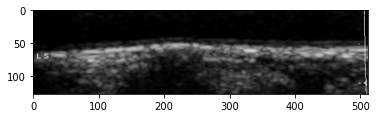

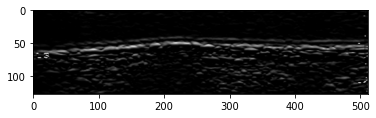

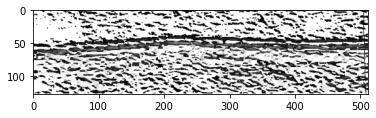

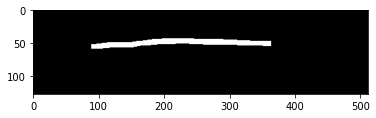

#--------------


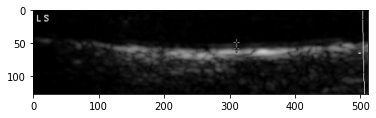

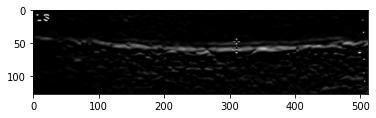

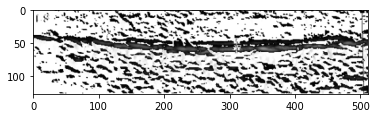

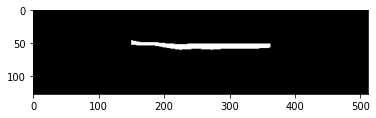

#--------------


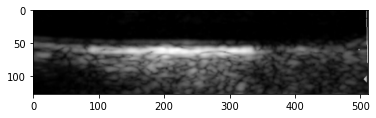

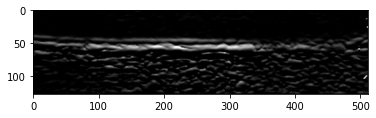

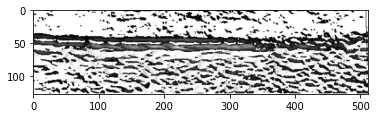

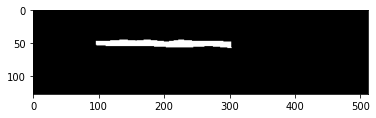

#--------------


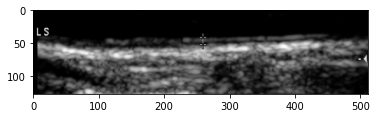

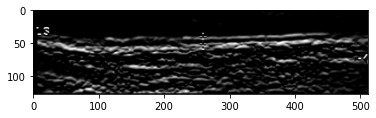

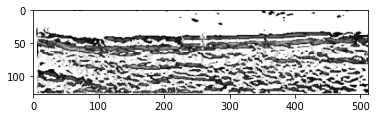

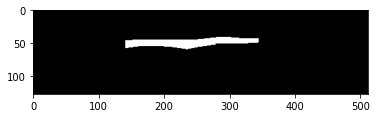

#--------------


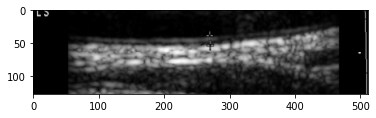

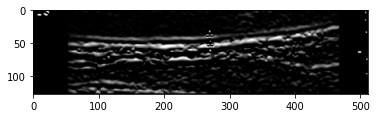

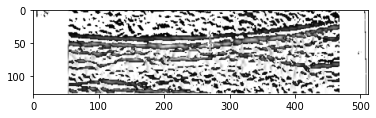

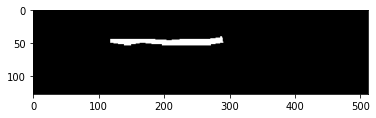

#--------------


In [ ]:
import matplotlib.pyplot as plt
print(botmasks.shape)
print(botimgs.shape)
for i in range(5):
  for j in range(3):
    plt.imshow(botimgs[i][j], cmap ='gray')
    plt.show()
  plt.imshow(botmasks[i], cmap ='gray')
  plt.show()
  print("#--------------")

In [ ]:
#兩個input channel:sobel、prewitt
def unet(Inshape):
    from keras import losses
    input1 = Input(shape=Inshape)
    input2 = Input(shape=Inshape)
    inputs = concatenate([input1, input2], axis = 3)
    conv1 = Conv2D(32, (3, 3), padding = 'same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)
    conv1 = Conv2D(32, (3, 3), padding = 'same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #512
    conv2 = Conv2D(64, (3, 3), padding = 'same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #256
    conv3 = Conv2D(128, (3, 3), padding = 'same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)
    conv3 = Conv2D(128, (3, 3), padding = 'same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #128
    conv4 = Conv2D(256, (3, 3), padding = 'same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ReLU()(conv4)
    conv4 = Conv2D(256, (3, 3), padding = 'same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    #128
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    #64
    conv5 = Conv2D(512, (3, 3), padding = 'same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = ReLU()(conv5)
    conv5 = Conv2D(512, (3, 3), padding = 'same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = ReLU()(conv5)
    drop5 = Dropout(0.5)(conv5)
    #64
    up6 = UpSampling2D(size = (2,2))(drop5)
    up6 = Conv2D(256, 2, padding = 'same')(up6)
    up6 = BatchNormalization()(up6)
    up6 = ReLU()(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(256, (3, 3), padding = 'same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ReLU()(conv6)
    conv6 = Conv2D(256, (3, 3), padding = 'same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ReLU()(conv6)
    drop6 = Dropout(0.5)(conv6)

    up7 = UpSampling2D(size = (2,2))(drop6)
    up7 = Conv2D(128, 2, padding = 'same')(up7)
    up7 = BatchNormalization()(up7)
    up7 = ReLU()(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(128, (3, 3), padding = 'same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ReLU()(conv7)
    conv7 = Conv2D(128, (3, 3), padding = 'same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ReLU()(conv7)
    drop7 = Dropout(0.5)(conv7)

    up8 = UpSampling2D(size = (2,2))(drop7)
    up8 = Conv2D(64, 2, padding = 'same')(up8)
    up8 = BatchNormalization()(up8)
    up8 = ReLU()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, (3, 3), padding = 'same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ReLU()(conv8)
    conv8 = Conv2D(64, (3, 3), padding = 'same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ReLU()(conv8)
    drop8 = Dropout(0.5)(conv8)
    
    up9 = UpSampling2D(size = (2,2))(drop8)
    up9 = Conv2D(32, 2, padding = 'same')(up9)
    up9 = BatchNormalization()(up9)
    up9 = ReLU()(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(32, (3, 3), padding = 'same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ReLU()(conv9)
    conv9 = Conv2D(32, (3, 3), padding = 'same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ReLU()(conv9)
    conv10 = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(conv9)
    model = Model(inputs = [input1, input2], outputs = conv10)

    model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), loss="binary_crossentropy",metrics=[tf.keras.metrics.Recall(thresholds=0.01),tf.keras.metrics.Precision(thresholds=0.01)])#tf.keras.metrics.MeanIoU(num_classes=2)
    return model
    

In [ ]:
botimgs = botimgs.astype(np.float32)/255
botmasks = botmasks.astype(np.float32)/255
V_botimgs = V_botimgs.astype(np.float32)/255
V_botmasks = V_botmasks.astype(np.float32)/255

In [ ]:
botimgs = botimgs.reshape(-1,3, 128, 512, 1)
botmasks = botmasks.reshape(-1, 128, 512, 1)
V_botimgs = V_botimgs.reshape(-1,3, 128, 512, 1)
V_botmasks = V_botmasks.reshape(-1, 128, 512, 1)
print(botimgs.shape)

(126, 3, 128, 512, 1)


In [ ]:
from tensorflow.keras.optimizers import Adam

IN = (botimgs.shape[2],botimgs.shape[3],botimgs.shape[4])
print(IN)
model = unet(IN)
history = model.fit([botimgs[:,1], botimgs[:,2]], botmasks, epochs= 30, batch_size=4, validation_data = ([V_botimgs[:,1], V_botimgs[:,2]], V_botmasks))


(128, 512, 1)
Epoch 1/30
32/32 [==============================] - 24s 221ms/step - loss: 0.3295 - recall: 0.9993 - precision: 0.0295 - val_loss: 0.9818 - val_recall: 1.0000 - val_precision: 0.0353
Epoch 2/30
32/32 [==============================] - 4s 130ms/step - loss: 0.0752 - recall: 0.9999 - precision: 0.0297 - val_loss: 0.2100 - val_recall: 1.0000 - val_precision: 0.0353
Epoch 3/30
32/32 [==============================] - 4s 130ms/step - loss: 0.0544 - recall: 0.9987 - precision: 0.0366 - val_loss: 0.1520 - val_recall: 1.0000 - val_precision: 0.0353
Epoch 4/30
32/32 [==============================] - 4s 131ms/step - loss: 0.0442 - recall: 0.9974 - precision: 0.0853 - val_loss: 0.1491 - val_recall: 1.0000 - val_precision: 0.0353
Epoch 5/30
32/32 [==============================] - 4s 132ms/step - loss: 0.0401 - recall: 0.9955 - precision: 0.1894 - val_loss: 0.1644 - val_recall: 0.9580 - val_precision: 0.0477
Epoch 6/30
32/32 [==============================] - 4s 132ms/step - loss: 0

In [ ]:
model.save("drive/MyDrive/大三專題/100-IMT-ImagesCY/model0811_sobel_prewitt.h5")

dict_keys(['loss', 'recall', 'precision', 'val_loss', 'val_recall', 'val_precision'])
{'loss': [0.32951438426971436, 0.07523398846387863, 0.05436895042657852, 0.04419206082820892, 0.04014556109905243, 0.03494798764586449, 0.03160271421074867, 0.03524557501077652, 0.029970485717058182, 0.026163510978221893, 0.02388491854071617, 0.022008802741765976, 0.02128099836409092, 0.023199066519737244, 0.022476578131318092, 0.020383799448609352, 0.02024053782224655, 0.020069323480129242, 0.028364555910229683, 0.02539830282330513, 0.019924357533454895, 0.019632142037153244, 0.018176136538386345, 0.018812038004398346, 0.0228066798299551, 0.018833348527550697, 0.01726340688765049, 0.01664903201162815, 0.01583072915673256, 0.014755169861018658], 'recall': [0.9993313550949097, 0.9998974204063416, 0.9986668229103088, 0.9974402785301208, 0.9955368638038635, 0.995594322681427, 0.993543267250061, 0.9909958243370056, 0.9965090751647949, 0.9958117008209229, 0.996041476726532, 0.997957170009613, 0.99751824140

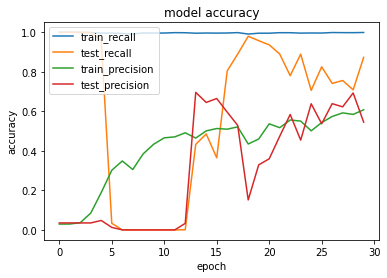

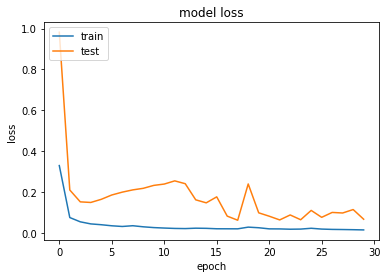

In [ ]:
print(history.history.keys())
print(history.history)
# summarize history for accuracy
"""
epoch_num =25
xvalue = list(range(epoch_num))
yvalue = list(range(10)/10)
"""
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_recall', 'test_recall','train_precision', 'test_precision'], loc='upper left')
plt.show()
#plt.savefig("drive/MyDrive/3.png")
# summarize history for loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()